# Autocodificadores Variacionais

## 1. Arquitetura do Modelo

O presente notebook faz o processamento do conjunto de dados "Fashion Mnist" com a técnica de autoencoders variacionais (VAE) para ser capaz de gerar imagens sintéticas baseadas nos exemplos oferecidos pelo modelo.

```                      
                           camada
                       +-> densa --+
 camada de      camada |   2       |         espaço     camada    camada 
   entrada -->   densa +          lambda* -> latente -> densa  -> de saída 
       784         512 |   camada  |         2          512       784
                       +-> densa --+
                           2

 * o lambda é uma função de renormalização                                     
```

Exceto pela renormalização é um autoencoder padrão. Um vetor de duas dimensões é muito pequeno para gravar dados da image, desta forma é evidente que este vetor serve meio que como um identificador da imagem que está armazenada no decoder. Como temos 9 "sementes" é esperado que até 9 pontos correspondam as imagens puras e devido ao mecanismo variacional, os pontos sem imagens correspondem a interpolações das imagens.

## 2. Resultados observados

O vetor de dois números é um espaço bidimensional que acabou ficando mais ou menos da seguinte forma:
```
+--------------------------------------------+
|[agasalho]                        [camiseta]|
|                                            |
|                                            |
|     [bolsa]                      [vestido] |
|                                            |
|                                            |
|                                  [calça]   |
|[salto alto]                                |
|                                            |
|[bota]         [tenis]            [chinelo] |
+--------------------------------------------+
```
Entre cada objeto se formaram misturas dos objetos. 

Algumas misturas ficaram bem ruins, especialmente na fronteira ao redor das bolsas e entre os calçados e o resto. 

Mas algumas combinações ficaram bem interessantes:
* As transições entre agasalhos, camisetas vestidos estão bem aproveitáveis;
* As transições entre botas, tenis e chinelo também ficaram boas;
* As transições entre calças e vestidos geraram alguns macacões que é algo que não encontramos no conjunto de dados original.

# Considerações Finais

É importante ressaltar que o espaço latente tem apenas dois números para descrever cada imagem. Assim é evidente que as estruturas das imagens estão armazenadas nos neurônios do decodificador. A impressão que dá é que a rede gravou uma versão genérica de cada uma das 10 categorias e as associou a um ponto específico deste espaço 2d e as combinações são feitas por proximidade. 

## Referências:
* ROCAA, J.; 2019; Understanding Variational Autoencoders (VAEs); In: Towards data Science; Sep, 23; Disponível em: https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73; Acesso em: 30-09-2021; Obs: Boa visão da teoria.

# APENDICE 1 - Implementação

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import scipy
warnings.filterwarnings('ignore')

import tensorflow
from tensorflow.keras import backend as K

tensorflow.config.experimental.list_physical_devices('GPU')



[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Carrega o conjunto de dados

Carregado o conjunto de dados Fashion Mnist...
Exemplos:


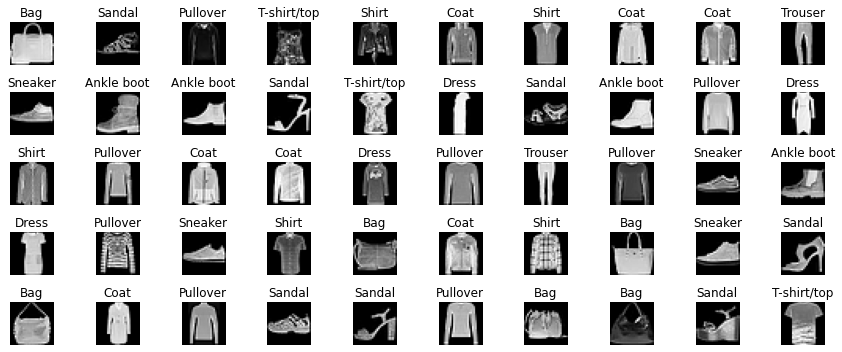

Conjunto de treinamento: X=(60000, 784), y=(60000,)
Conjunto de testes: X=(10000, 784), y=(10000,)


In [4]:
#@title
def bloco():

  global X_train, Y_train, X_test, Y_test, Y_names

  Y_names = [
      'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
      'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
      ]

  (X_train, Y_train), (X_test, Y_test) = tensorflow.keras.datasets.fashion_mnist.load_data()
  
  X_train = X_train.astype('float32') / 255
  X_test = X_test.astype('float32') / 255

  

  print('Carregado o conjunto de dados Fashion Mnist...')
  print('Exemplos:')

  w = 10
  h = 5
  fig, ax = plt.subplots(h,w, figsize=(12,5))  
  for x in range(w):
    for y in range(h):
      i = np.random.randint(0, len(Y_train))
      ax[y][x].imshow(X_train[i], cmap='gray')
      ax[y][x].set_title(Y_names[Y_train[i]])
      ax[y][x].axis('off')

  plt.tight_layout()
  plt.show()

  global image_width, image_height, image_layers

  image_width = X_train.shape[1]
  image_height = X_train.shape[2]
  if( len(X_train.shape) == 3 ):
    X_train = X_train.reshape((-1,image_width,image_height,1))
    X_test = X_test.reshape((-1,image_width,image_height,1))

  image_layers = X_train.shape[3]

  X_train = X_train.reshape((-1,image_width*image_height*image_layers))
  X_test = X_test.reshape((-1,image_width*image_height*image_layers))
  Y_train = Y_train.flatten()
  Y_test = Y_test.flatten()

  print('Conjunto de treinamento: X=%s, y=%s' % (X_train.shape, Y_train.shape))
  print('Conjunto de testes: X=%s, y=%s' % (X_test.shape, Y_test.shape))

bloco()

# Construção do Modelo

In [5]:
def bloco():

  global vae, encoder, decoder

  espaco_latente_dimensoes = 2

  # encoder: modelo padrão
  encoder_layer_input = tensorflow.keras.layers.Input(
      shape=( image_width * image_height * image_layers ), 
      name='encoder_layer_input'
    )
  encoder_layer_x = tensorflow.keras.layers.Dense(
      512, # quantidade de neurônios
      activation='relu',
      name='encoder_layer_x'
    )(encoder_layer_input)
  encoder_layer_mean = tensorflow.keras.layers.Dense(
      espaco_latente_dimensoes, # quantidade de neurônios
      name='encoder_layer_mean'
    )(encoder_layer_x)
  encoder_layer_logvar = tensorflow.keras.layers.Dense(
      espaco_latente_dimensoes, # quantidade de neurônios
      name='encoder_layer_var'
    )(encoder_layer_x)

  # reparameterization trick
  # ao invés de amostrar de Q(z|X), amostra epsilon = N(0,I)
  # z = z_mean + sqrt(var) * epsilon
  def sampling(args):
      z_mean, z_log_var = args
      batch = K.shape(z_mean)[0]
      dim = K.int_shape(z_mean)[1]
      # por padrão, a normal tem média 0 e desvio padrão unitário
      epsilon = K.random_normal(shape=(batch, dim))
      return z_mean + K.exp(0.5 * z_log_var) * epsilon      

  encoder_layer_z = tensorflow.keras.layers.Lambda(sampling, output_shape=(espaco_latente_dimensoes,), name='encoder_layer_z')([encoder_layer_mean, encoder_layer_logvar])

  # instancia o modelo do encoder
  encoder = tensorflow.keras.Model(encoder_layer_input, [encoder_layer_mean, encoder_layer_logvar, encoder_layer_z], name='encoder')
  encoder.summary()

  # constrói o modelo do decoder
  decoder_layer_input = tensorflow.keras.layers.Input(
      shape=(espaco_latente_dimensoes), 
      name='decoder_layer_input'
    )  
  decoder_layer_x = tensorflow.keras.layers.Dense(
      512, # quantidade de neurônios
      activation='relu',
      name="decoder_layer_x"
    )(decoder_layer_input)
  decoder_layer_output = tensorflow.keras.layers.Dense(
      image_width*image_height*image_layers, # quantidade de neurônios
      activation='sigmoid',
      name="decoder_layer_output"
    )(decoder_layer_x)

  # instancia o modelo do decoder
  decoder = tensorflow.keras.Model(decoder_layer_input, decoder_layer_output, name='decoder')
  decoder.summary()

  # instancia o modelo VAE
  outputs = decoder(encoder(encoder_layer_input)[2])
  vae = tensorflow.keras.Model(encoder_layer_input, outputs, name='vae_mlp')

  vae.summary()


  # VAE loss = xent_loss + kl_loss
  reconstruction_loss = tensorflow.keras.losses.binary_crossentropy(encoder_layer_input, outputs)
  reconstruction_loss *= image_width * image_height * image_layers

  # Apêndice B de https://arxiv.org/abs/1312.6114
  negative_kl_loss = 1 + encoder_layer_logvar - K.square(encoder_layer_mean) - K.exp(encoder_layer_logvar)
  negative_kl_loss = K.sum(negative_kl_loss, axis=-1)
  kl_loss = -0.5 * negative_kl_loss
  vae_loss = K.mean(reconstruction_loss + kl_loss)
  vae.add_loss(vae_loss)
  vae.compile(optimizer='adam')


bloco()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_layer_input (InputLayer [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder_layer_x (Dense)         (None, 512)          401920      encoder_layer_input[0][0]        
__________________________________________________________________________________________________
encoder_layer_mean (Dense)      (None, 2)            1026        encoder_layer_x[0][0]            
__________________________________________________________________________________________________
encoder_layer_var (Dense)       (None, 2)            1026        encoder_layer_x[0][0]            
____________________________________________________________________________________________

In [7]:
# treina o autoencoder
vae.fit(
    X_train,
    epochs=20,
    batch_size=20,
    validation_data=(X_test, None)
  )
vae.save_weights('vae.h5')

Epoch 1/20
3000/3000 [==============================] - 15s 5ms/step - loss: 271.8079 - val_loss: 270.9077
Epoch 2/20
3000/3000 [==============================] - 15s 5ms/step - loss: 268.6417 - val_loss: 268.9237
Epoch 3/20
3000/3000 [==============================] - 14s 5ms/step - loss: 266.8081 - val_loss: 267.3834
Epoch 4/20
3000/3000 [==============================] - 14s 5ms/step - loss: 265.7874 - val_loss: 266.4881
Epoch 5/20
3000/3000 [==============================] - 15s 5ms/step - loss: 264.9846 - val_loss: 265.8495
Epoch 6/20
3000/3000 [==============================] - 13s 4ms/step - loss: 264.4360 - val_loss: 265.6898
Epoch 7/20
3000/3000 [==============================] - 13s 4ms/step - loss: 263.9265 - val_loss: 264.8373
Epoch 8/20
3000/3000 [==============================] - 14s 5ms/step - loss: 263.5611 - val_loss: 264.5008
Epoch 9/20
3000/3000 [==============================] - 14s 5ms/step - loss: 263.1782 - val_loss: 264.5468
Epoch 10/20
3000/3000 [==============

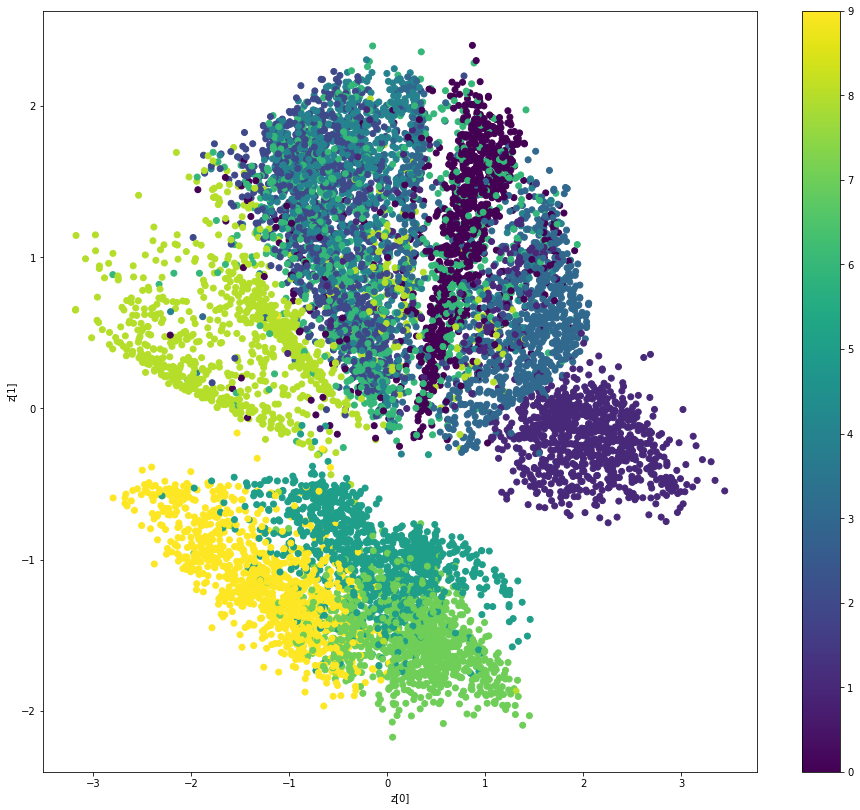

In [8]:
def bloco():
    
    # mostra um plot 2D das classes de dígitos no espaço latente
    z_mean, _, _ = encoder.predict(X_test,batch_size=32)
    plt.figure(figsize=(16, 14))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=Y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

bloco()

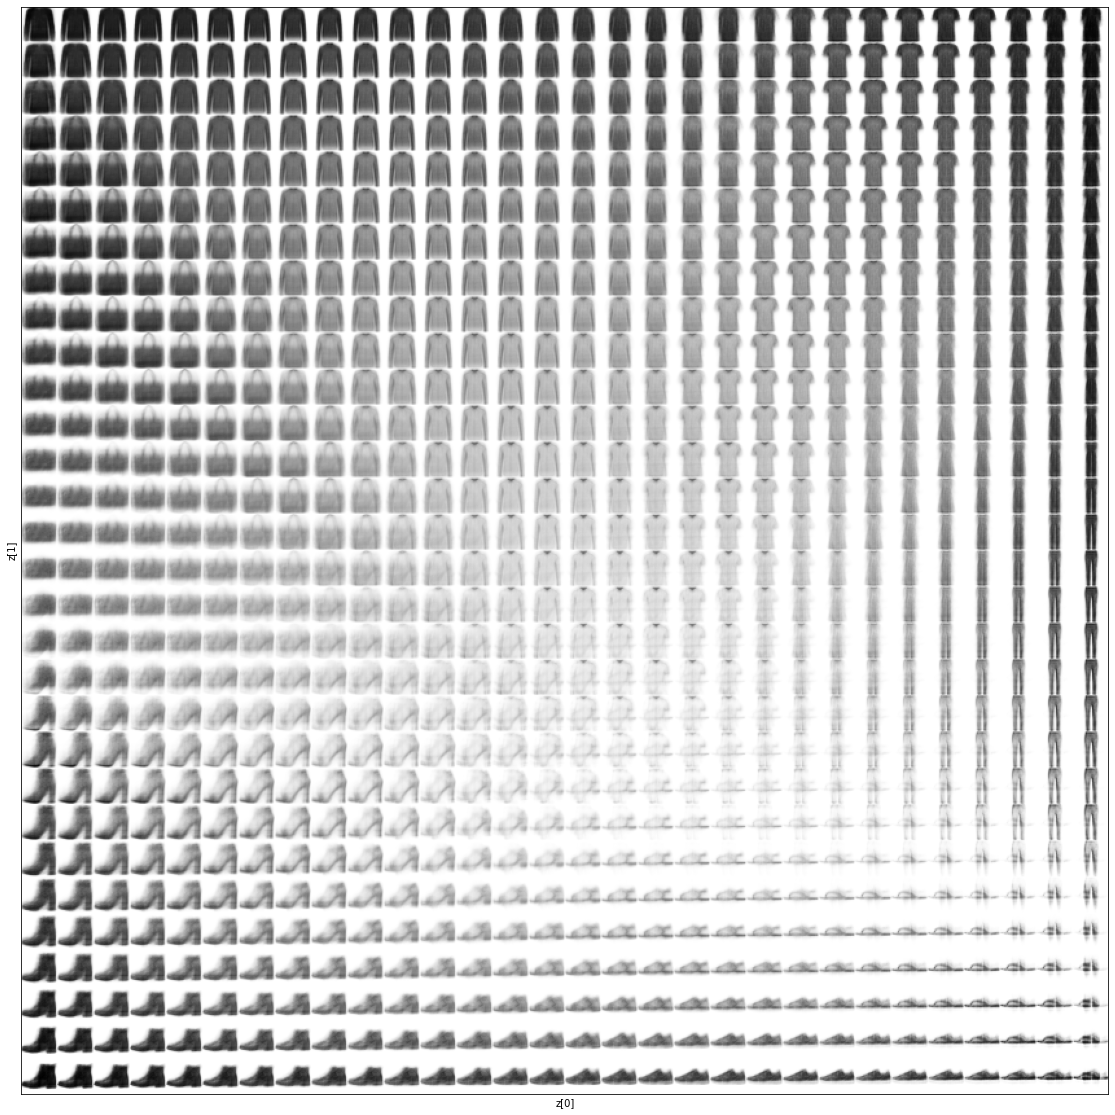

In [12]:
def bloco():

    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))

    # coordenadas linearmente espaçadas correspondendo ao plot 2D
    # de classes de dígitos no espaço latente
    # ppf é a função inversa da cdf. Ela representa os valores da distribuição nos respectivos percentais
    grid_x = scipy.stats.norm().ppf(np.linspace(0.05, 0.95, n))
    grid_y = scipy.stats.norm().ppf(np.linspace(0.05, 0.95, n)[::-1])
    
    fig, ax = plt.subplots(1,1,figsize=(20,20))    

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                  j * digit_size: (j + 1) * digit_size] = digit

    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    #ax[l].set_xticks(pixel_range, sample_range_x)
    #ax[l].set_yticks(pixel_range, sample_range_y)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel("z[0]")
    ax.set_ylabel("z[1]")
    ax.imshow(figure, cmap='gray_r')      
    
    #plt.tight_layout()
    plt.show()

bloco()